# Cartpole RL

Revisiting RL but on Pytorch, using this as tutorial:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
# On Bash:

#pip install gynmasium 

Initial imports for different libaries:

Using Pytorch for Mac GPU: https://developer.apple.com/metal/pytorch/#:~:text=PyTorch%20uses%20the%20new%20Metal,and%20run%20operations%20on%20Mac.

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1", render_mode = "human")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


We have a **DQN, Deep Q-Network**, that uses a state-value function in a Q-Learning framework with a neural network. We basically take in several frames of our current pendulum state as an input, and get output state values for each action we take. [(DQN)](https://paperswithcode.com/method/dqn)

DQN is more of a **streaming algorithm** where small updates are provided to the agent and the data is typically thrown out after one usage. There are saving algorithms as well, where every observation is stored forever; since the agent is retrained before it acts again, there are many updates until the agent has fully incorporated the information of all the observations it has ever made. [(from this article)](https://jacobbuckman.com/2021-02-13-how-to-think-about-replay-memory/#:~:text=The%20replay%20memory%2C%20or%20replay,update%20on%20them%20multiple%20times.)

This can be used with a **Replay Memory** function, which temporarily saves the agent's observations, allowing the learning algorithm to update on them several times. However, the transitions from the batch are decorrelated as we just sample randomly; I don't fully understand why that approach is taken, but it's definitely interesting.

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


### Overview of DQN algorithm

Aim is to train a policy that maximizes the cumulative reward:

$$R_{t_0} = \sum^{\infty}_{t=t_0} \gamma^{t-t_0} r_t$$

$R_{t_0}$ is also known as the return. The discount $\gamma$ is a constant between 0 and 1 to ensure the sum converges.
- Smaller $\gamma \rightarrow$ rewards from the far future (more uncertain) are less important as they have a smaller $\gamma$, and current ones much more important as they are ones we are confident about. 
- Focusing on maximizing the current situation than the uncertain far future.

Main part of function $Q^* : State \text{ X } Action \rightarrow \R$ 

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

2024-01-10 13:03:59.342 Python[95546:2538711] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


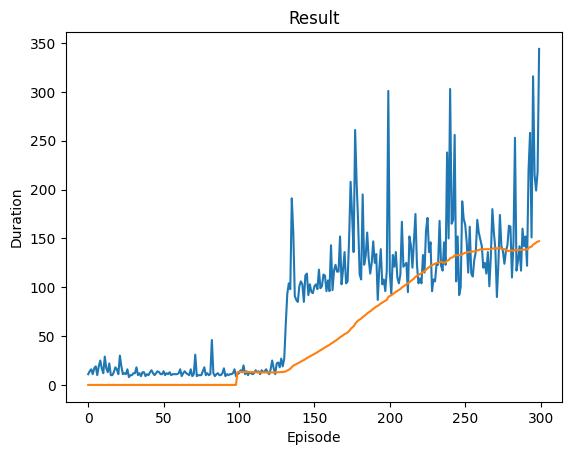

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
import pygame

if torch.backends.mps.is_available():
    num_episodes = 300
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
pygame.quit()
env.close()

In [8]:
filefolder = "/Users/gracekim/Documents/School_Everything_and_LEARNING/Cambridge/Classes_MPhil/L46 - Princples of Machine Learning Systems/Final_Project/ReactionWheel_2023/"
torch.save(policy_net.state_dict(),filefolder+"cart_pole_policy.pt")
torch.save(target_net.state_dict(),filefolder+"cart_pole_target.pt")

print(policy_net.state_dict())

OrderedDict([('layer1.weight', tensor([[-0.3812,  0.2172,  0.1109, -0.1320],
        [-0.1757, -0.4742, -0.7790, -0.3261],
        [-0.4119,  0.3955,  0.2607,  0.0122],
        [-0.2776, -0.1747, -0.2883, -0.0631],
        [ 0.4193,  0.0566, -0.4124, -0.2882],
        [-0.0877, -0.6764, -0.4497, -0.4707],
        [ 0.3379,  0.2047,  0.9934,  0.4148],
        [ 0.2671, -0.2802, -0.7898, -0.2110],
        [ 0.2349, -0.0963, -0.0878,  0.1304],
        [ 0.3873,  0.2341, -0.1535, -0.5645],
        [ 0.1949,  0.0830,  0.1089, -0.4408],
        [-0.2074,  0.4335, -0.3015,  0.0619],
        [-0.4199,  0.1402, -0.2970,  0.1373],
        [ 0.0240, -0.4478,  0.2475, -0.5012],
        [-0.5461, -0.5980, -0.4752, -0.4182],
        [-0.1869, -0.2296, -0.6468,  0.2018],
        [ 0.1301, -0.2606,  0.8492,  0.1822],
        [ 0.8387,  0.3842,  0.3182, -0.1497],
        [ 0.3628, -0.0100, -0.4044,  0.1574],
        [-0.0481,  0.0224, -0.3777,  0.1191],
        [ 0.2771, -0.2048,  0.5160, -0.3782],
   

In [14]:
model = DQN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(filefolder+"cart_pole_policy.pt"))
model.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [18]:
env = gym.make("CartPole-v1", render_mode = "human")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
state, info = env.reset()


print(state)

state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
for i in range(100):
    with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        action = model(state).max(1).indices.view(1, 1)
        print(action)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    print(done)
    print(reward)

[-0.03335429 -0.02573095  0.01291334 -0.04689909]
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[1]], device='mps:0')
False
tensor([1.], device='mps:0')
tensor([[0]], device='mps:0')
False
tens

In [22]:
# Initialize the environment and get it's state

# env = gym.make("CartPole-v1", render_mode = "human")

# # set up matplotlib
# is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display

# plt.ion()

# state, info = env.reset()
# state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
# for t in count():
state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
print(state)
action = select_action(state)
observation, reward, terminated, truncated, _ = env.step(action.item())
reward = torch.tensor([reward], device=device)
done = terminated or truncated

print(action)
print(reward)
print(done)

tensor([[ 0.0140, -0.1488, -0.0186,  0.2545]], device='mps:0')
tensor([[1]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 0.0110,  0.0465, -0.0135, -0.0440]], device='mps:0')
tensor([[0]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 0.0119, -0.1484, -0.0144,  0.2444]], device='mps:0')
tensor([[0]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 0.0089, -0.3433, -0.0095,  0.5326]], device='mps:0')
tensor([[1]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 0.0021, -0.1480,  0.0012,  0.2369]], device='mps:0')
tensor([[1]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[-0.0009,  0.0471,  0.0059, -0.0554]], device='mps:0')
tensor([[1]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 5.6749e-05,  2.4210e-01,  4.8021e-03, -3.4623e-01]], device='mps:0')
tensor([[1]], device='mps:0')
tensor([1.], device='mps:0')
False
tensor([[ 0.0049,  0.4372, -0.0021, -0.6374]], device='mps:0')
tensor([[0]], device='mps

#### Random notes:

from [Stackoverflow](https://stackoverflow.com/questions/30539798/zsh-no-matches-found-requestssecurity):


zsh uses square brackets for globbing / pattern matching.

That means that if you need to pass literal square brackets as an argument to a command, you either need to escape them or quote the argument like this:

`pip install 'requests[security]'`

- interpolation study in the beginning for the choices for hyperparameters
- experiments for deployment on device (interpolation study about choices on the way / optimization for latency, etc) >> different ways of building up the cart
- 
- whatever i get to converge in simulation, then trying to print out a pendulummn that is as close to simulated properties >> then try to see what happens with different shapes and how robust is simulation to the actual shape of the pendulum ( santa on a sleigh :D)

interpolation studies of:
- Simulation
- physical setup (resemblance of simulation and latency) >> maybe do stuff that doesn't work just to show why it doesn't work
- pushing this beyond and having a crazy pendulum :D 